In [16]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql import Row
import pandas as pd
from pyspark.sql.types import StringType, NumericType, BooleanType, TimestampType, DecimalType, ArrayType, StructType
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import col, isnan, when, count
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [9]:
spark = SparkSession.builder \
    .appName("BasalamAnalysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

df = spark.read.csv("/kaggle/input/basalam-comments-and-products/BaSalam.products.csv", header=True, inferSchema=True)

# Convert column names to a pandas DataFrame for table display
columns_df = spark.createDataFrame([Row(Column_Name=col_name) for col_name in df.columns])
columns_pd = columns_df.toPandas()

print("Columns in the Dataset:")
display(columns_pd)

Columns in the Dataset:


,Column_Name
0,_id
1,_score
2,sales_count_week
3,name
4,price
5,status_id
6,status_title
7,stock
8,photo_MEDIUM
9,photo_SMALL


### Histograms (after outlier removal for better visualization)

24


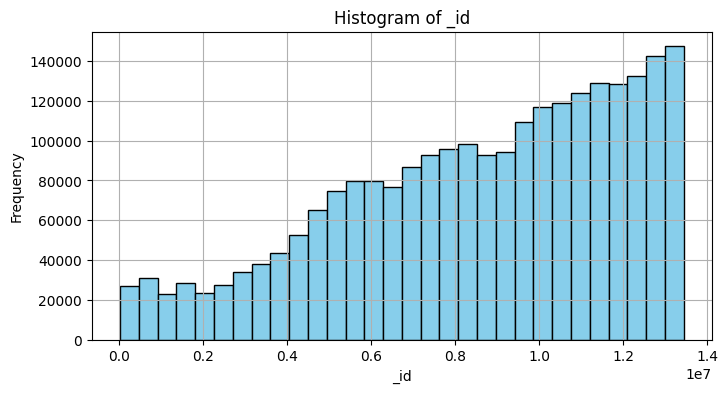

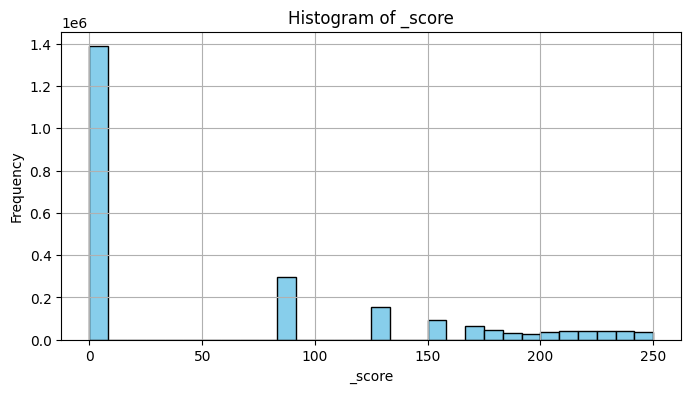

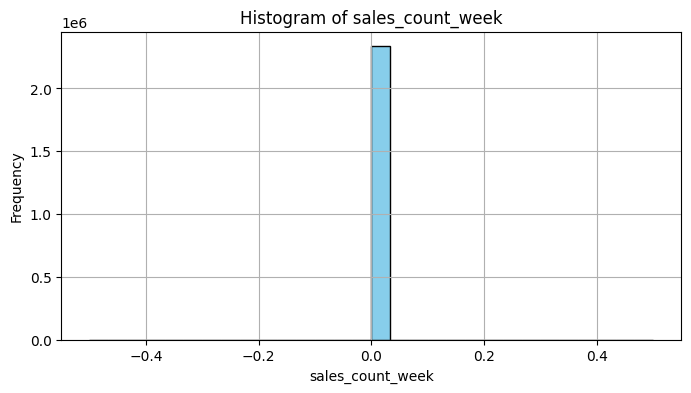

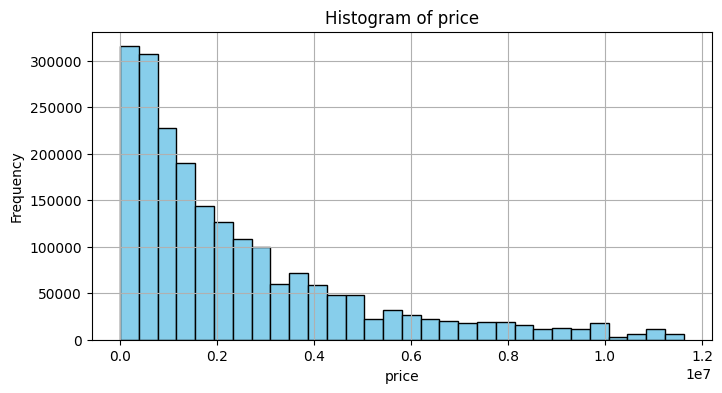

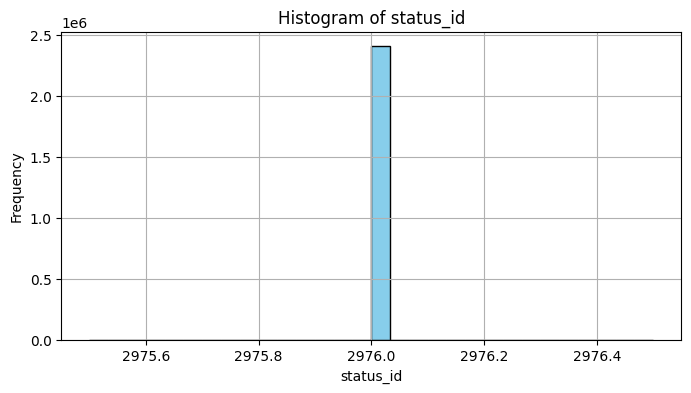

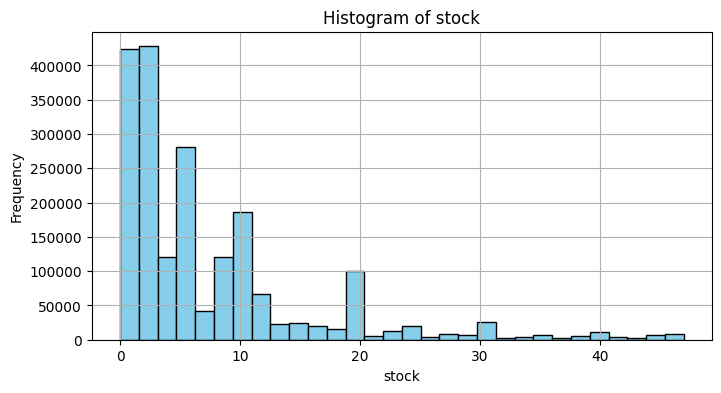

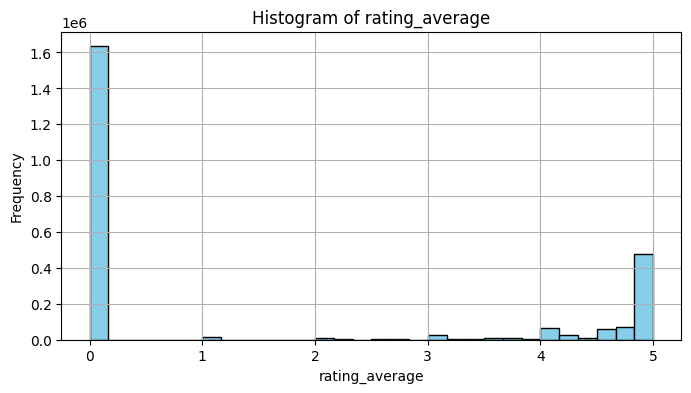

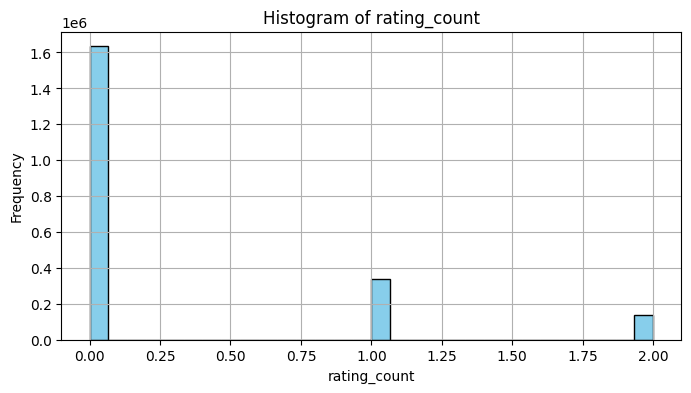

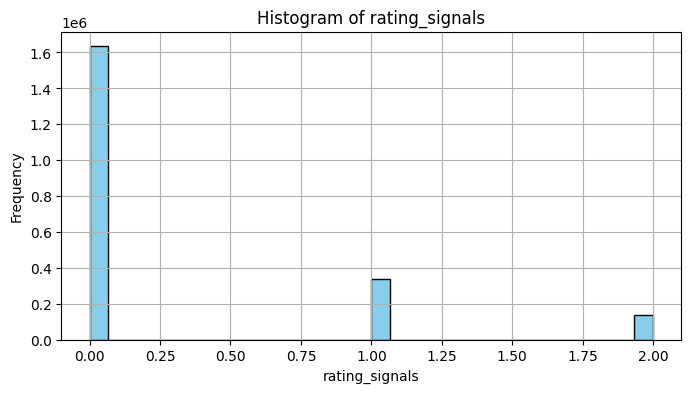

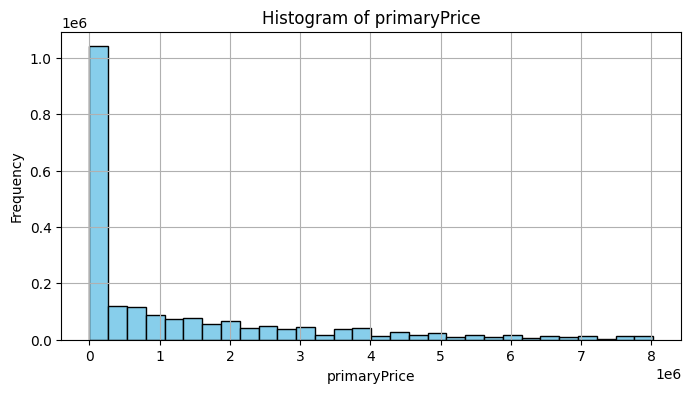

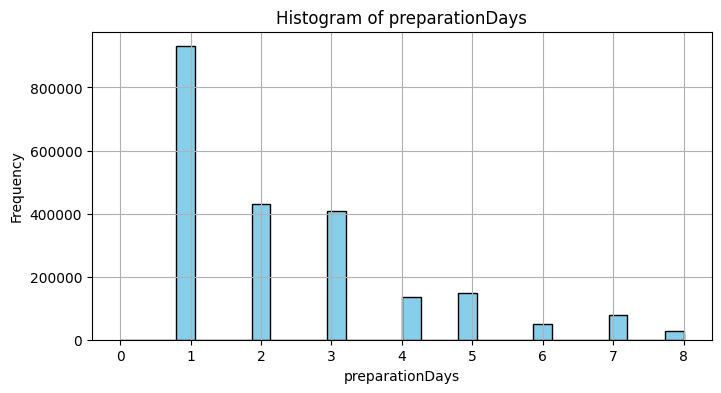

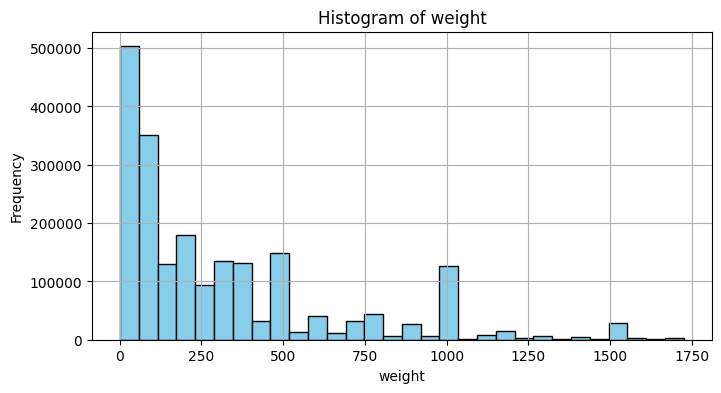

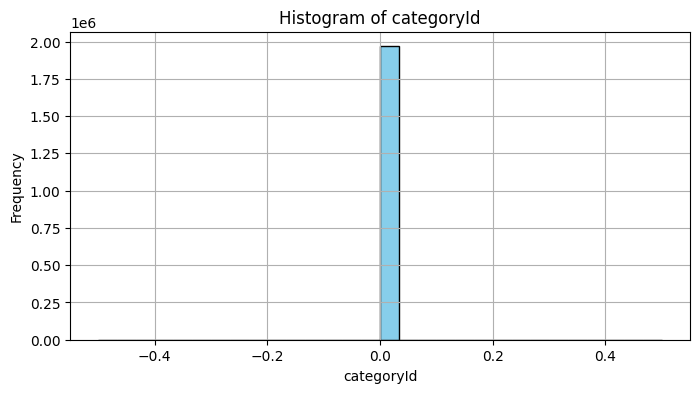

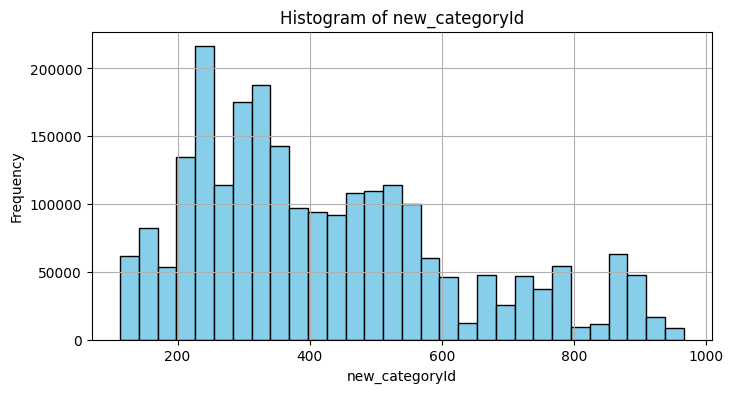

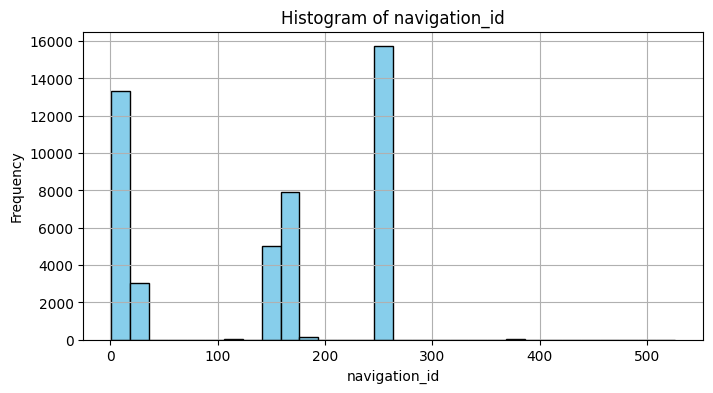

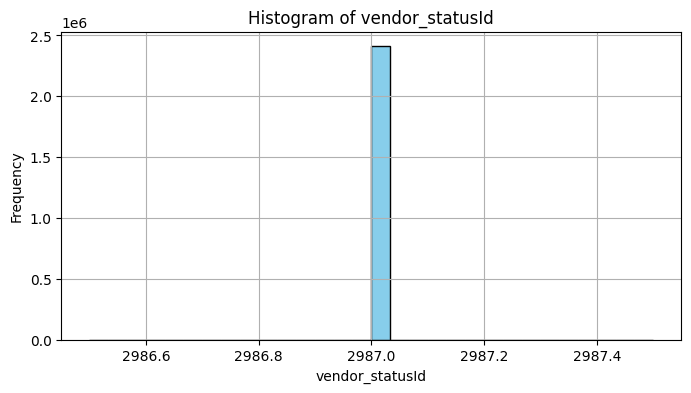

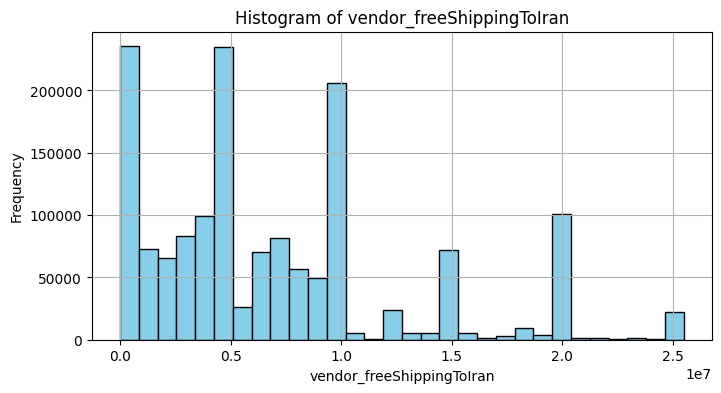

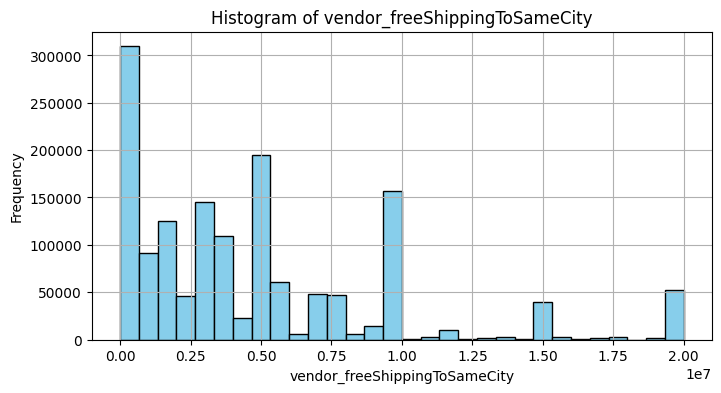

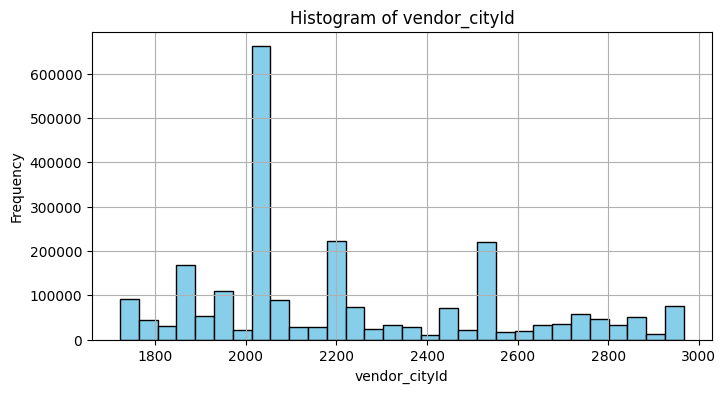

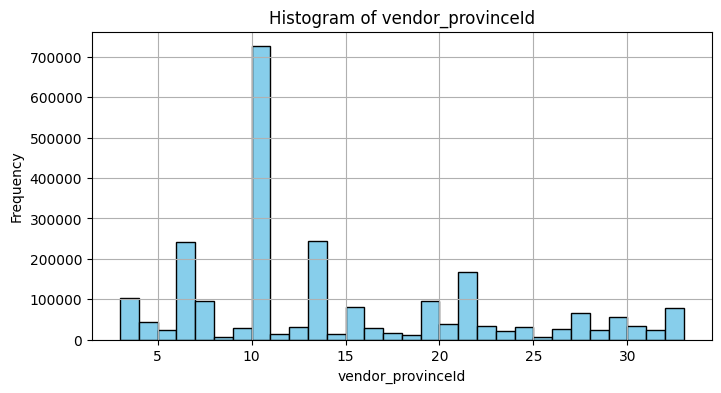

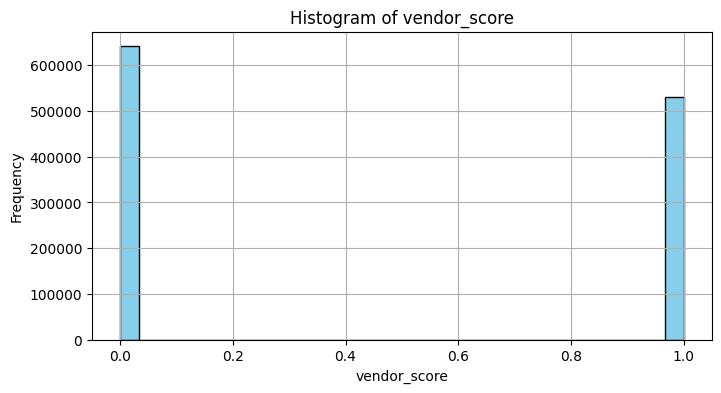

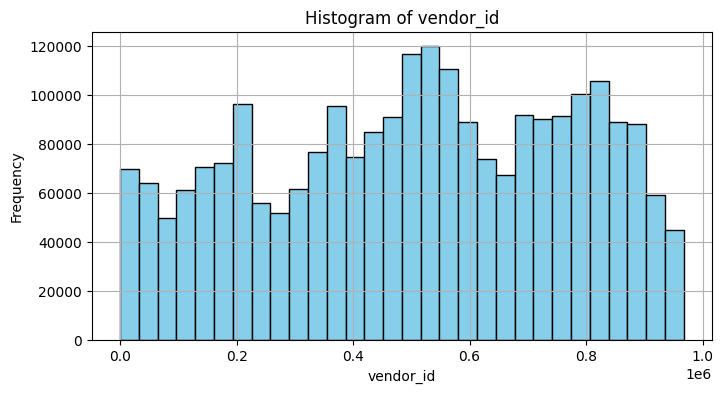

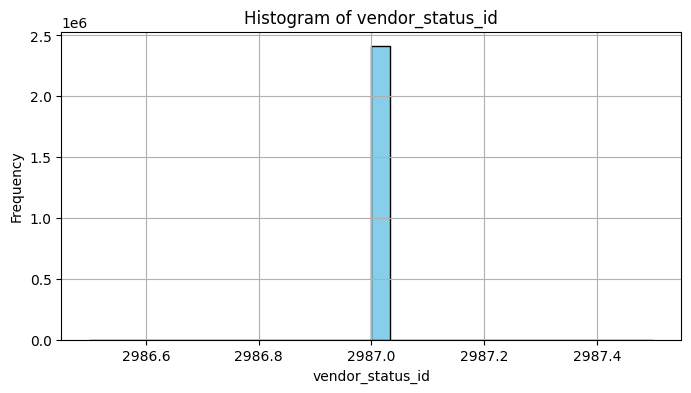

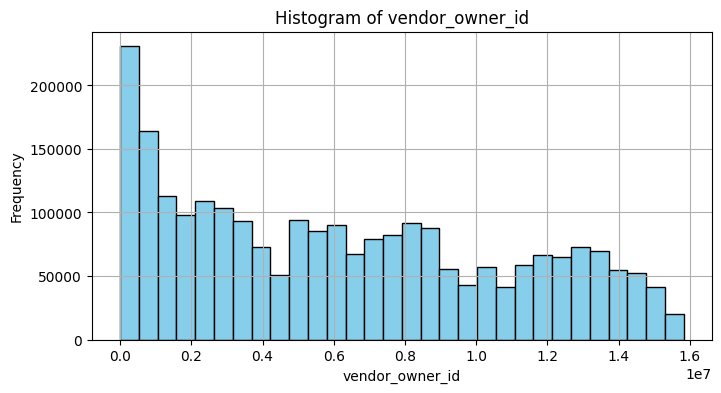

In [14]:
# 1. Select only numeric columns
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]
print(len(numeric_cols))
# 2. For each numeric column, plot histogram
for col in numeric_cols:
    # Drop nulls
    data = df.select(col).dropna()
    
    # Collect to Pandas
    values = np.array(data.rdd.map(lambda row: row[0]).collect())
    
    # Remove outliers: keep values within [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    filtered_values = values[(values >= lower_bound) & (values <= upper_bound)]
    
    # Plot
    plt.figure(figsize=(8, 4))
    plt.hist(filtered_values, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

### Nulls Percentage

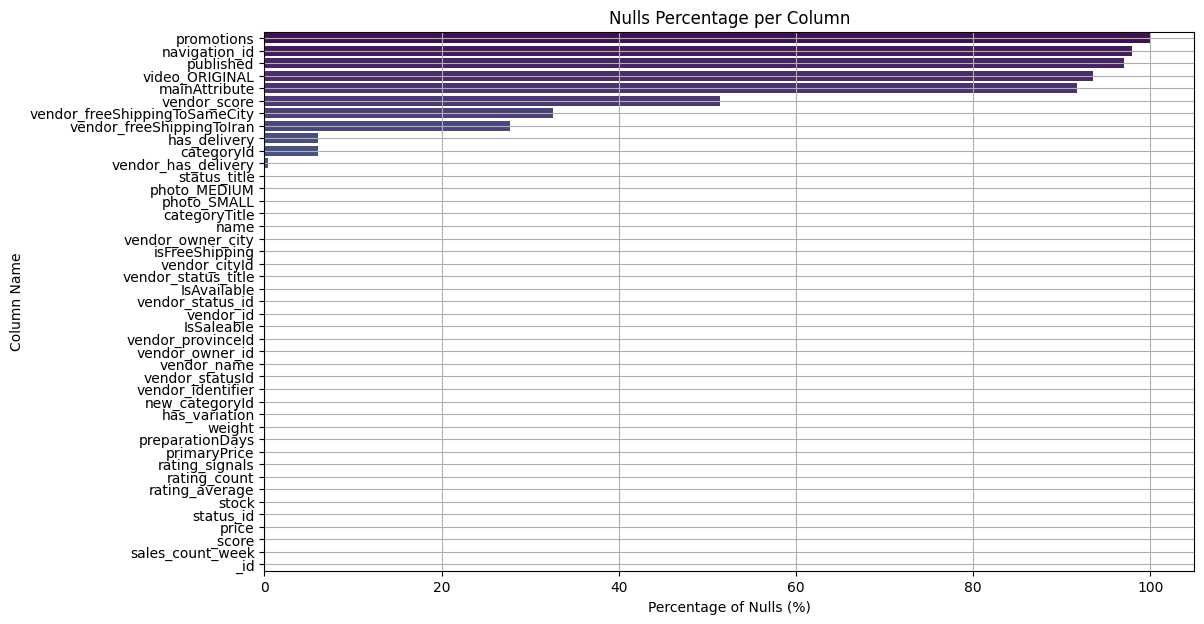

In [13]:
# Create a dictionary to store nulls percentage
nulls_percentage = {}

total_rows = df.count()

for col in df.columns:
    null_count = df.filter(F.col(col).isNull()).count()
    percent = (null_count / total_rows) * 100
    nulls_percentage[col] = percent

# Convert to Pandas DataFrame for easy visualization
nulls_df = pd.DataFrame(list(nulls_percentage.items()), columns=['Column', 'Null_Percentage'])
nulls_df = nulls_df.sort_values(by='Null_Percentage', ascending=False)

# Display
plt.figure(figsize=(12, 7))
sns.barplot(x='Null_Percentage', y='Column', data=nulls_df, palette='viridis')
plt.title('Nulls Percentage per Column')
plt.xlabel('Percentage of Nulls (%)')
plt.ylabel('Column Name')
plt.grid(True)
plt.show()


### Correlation Heatmap

25/04/27 22:52:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


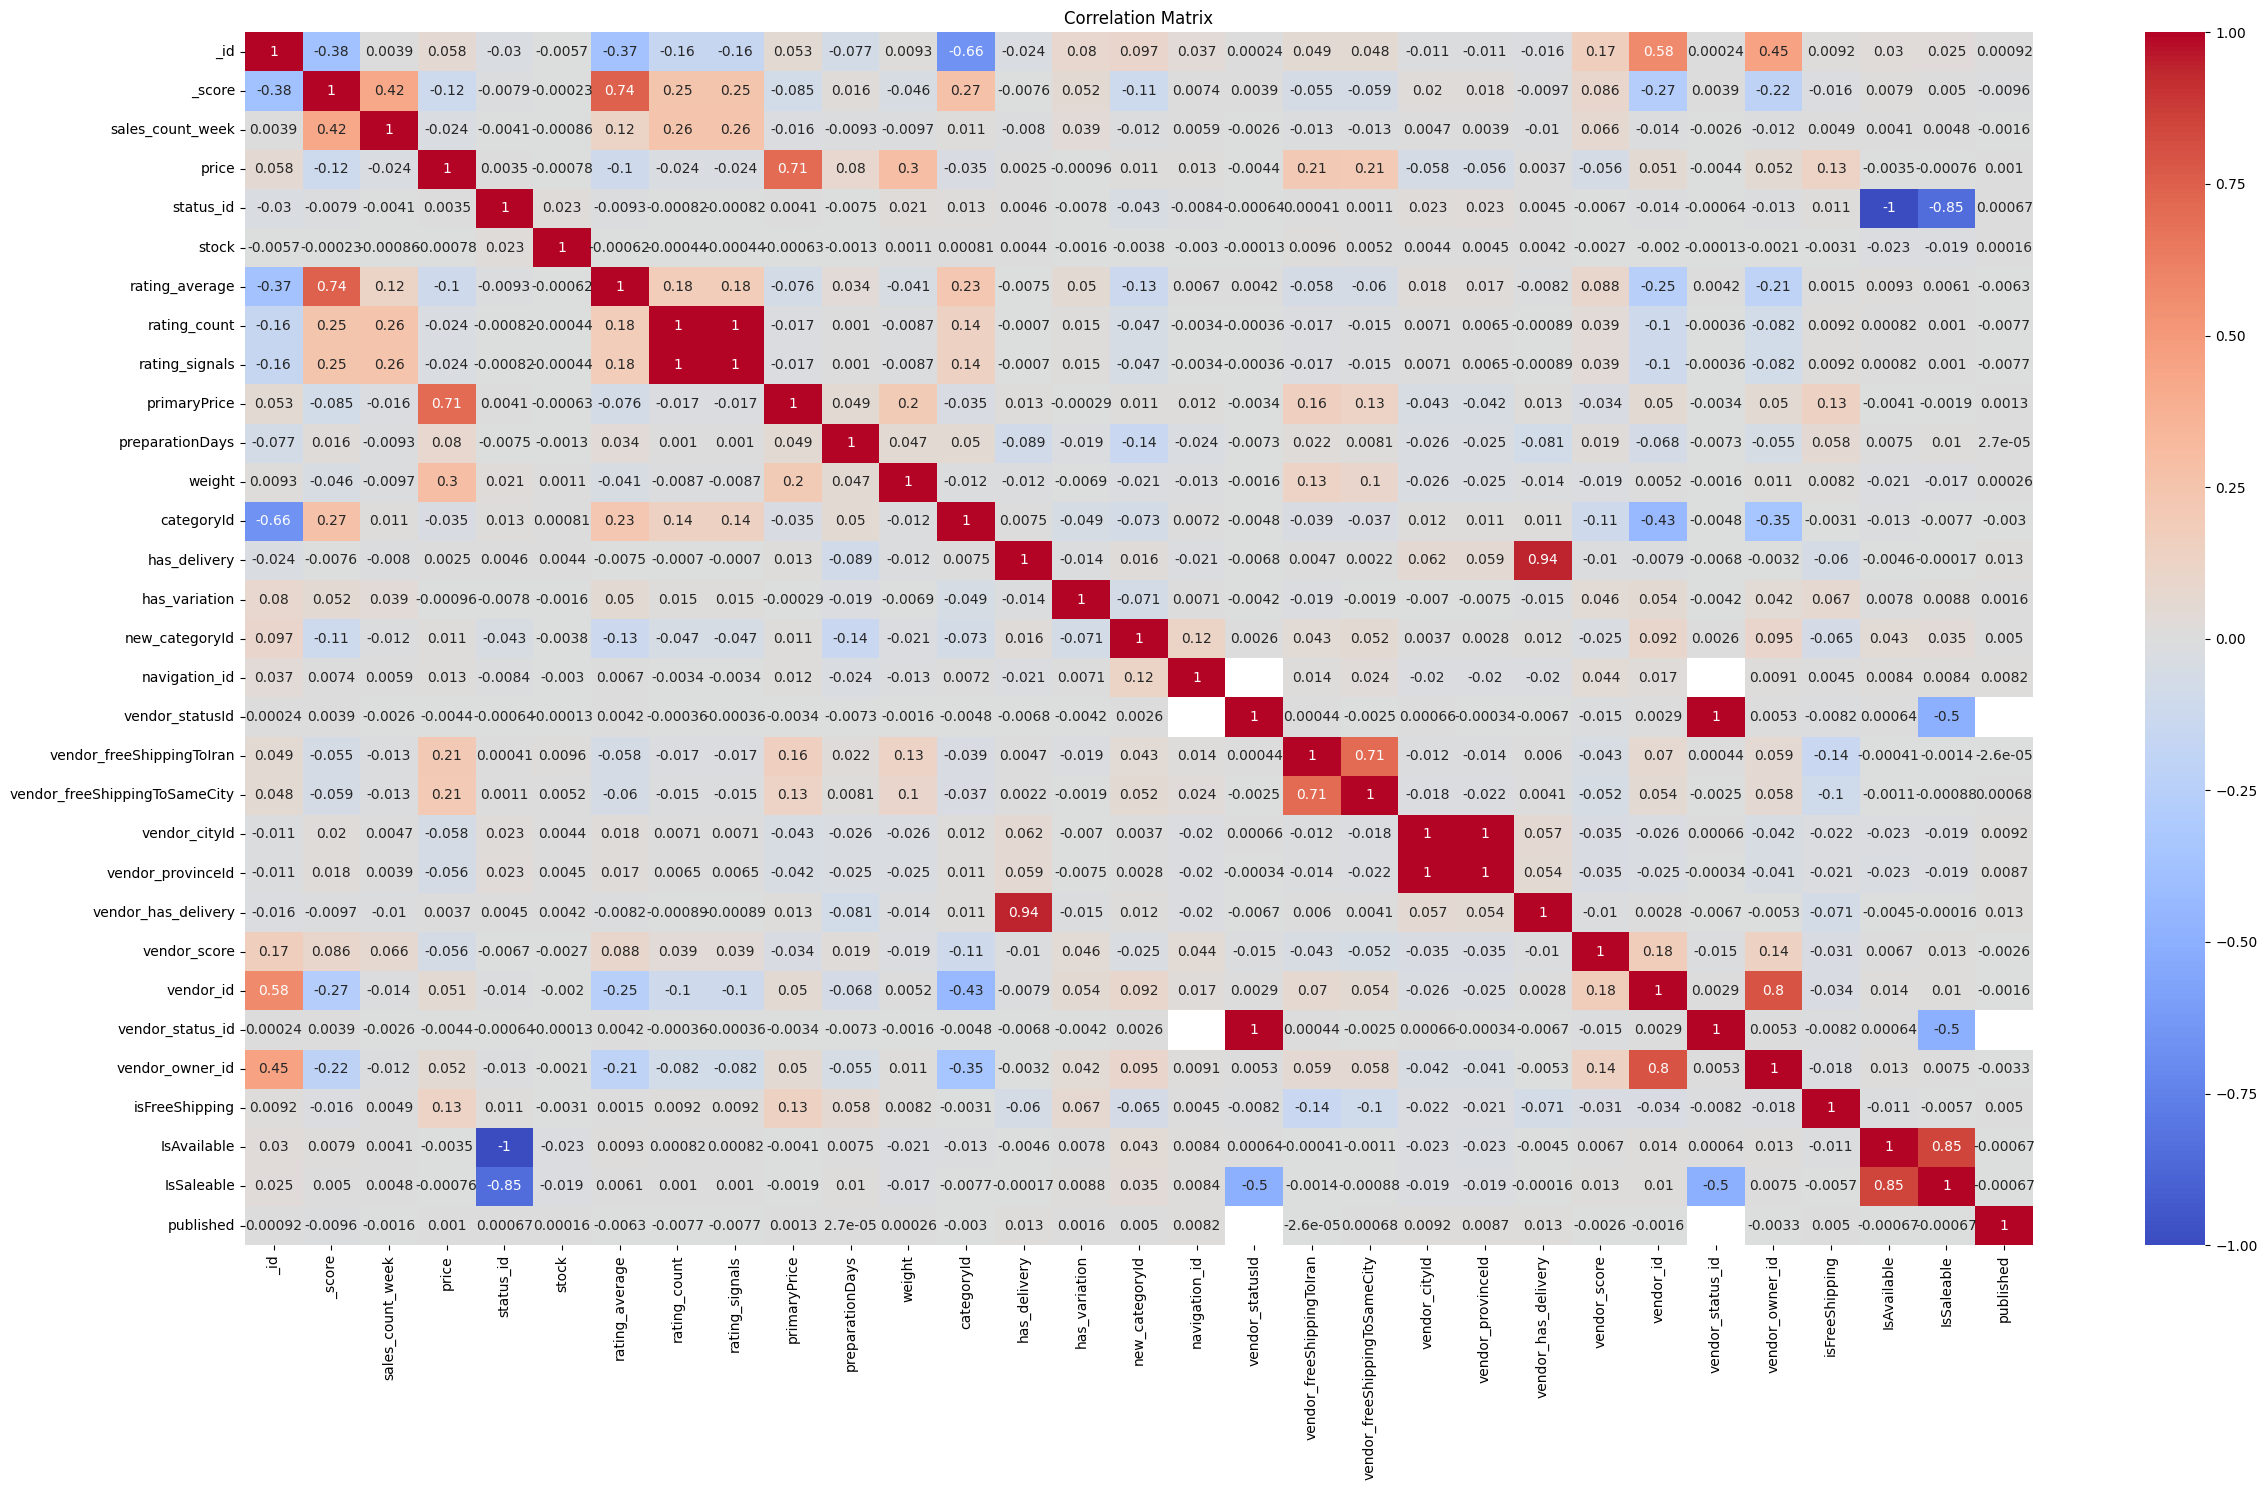

In [15]:
from pyspark.sql.functions import col, stddev
from pyspark.sql.types import DoubleType, IntegerType, BooleanType
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select numeric/boolean features
all_features = [
    f.name for f in df.schema.fields
    if isinstance(f.dataType, (DoubleType, IntegerType, BooleanType))
]

# 2. Convert Boolean columns to Integer (True/False → 1/0)
for col_name in all_features:
    if isinstance(df.schema[col_name].dataType, BooleanType):
        df = df.withColumn(col_name, col(col_name).cast("integer"))

# 3. Remove constant columns
constant_cols = []
for col_name in all_features:
    std_dev = df.select(stddev(col_name)).collect()[0][0]
    if std_dev == 0 or std_dev is None:
        constant_cols.append(col_name)

# Keep only useful columns
useful_features = [col for col in all_features if col not in constant_cols]

# 4. Plot Correlation Matrix
def plot_correlation_matrix(df, columns):
    correlation_data = df.select(columns).toPandas()
    correlation_matrix = correlation_data.corr()

    plt.figure(figsize=(25, 15))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(df, useful_features)